In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2024 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

# SOC Flowsheet --- PID Control
Author: Douglas Allan
Maintainer: Douglas Allan  
Updated: 2024-26-03

ADD MORE LATER

In [2]:
import os
import time
from enum import Enum
import pandas as pd
import numpy as np

import pyomo.environ as pyo
from pyomo.common.fileutils import this_file_dir
from pyomo.common.collections import ComponentSet, ComponentMap
from pyomo.util.calc_var_value import calculate_variable_from_constraint

import idaes
import idaes.core.util.scaling as iscale
from pyomo.dae import ContinuousSet, DerivativeVar
from idaes.core.solvers import petsc
import idaes.logger as idaeslog
import idaes.core.util.model_serializer as ms
from idaes.core.util.model_statistics import degrees_of_freedom as dof
from idaes_examples.mod.power_gen.soc_dynamic_flowsheet import SocStandaloneFlowsheet as SocFlowsheet
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from idaes.models.control.controller import ControllerType, ControllerMVBoundType, ControllerAntiwindupType
# from save_results import save_results
from idaes.models.properties import iapws95
from idaes.core.util.model_statistics import degrees_of_freedom as dof

In [3]:
class OperatingScenario(Enum):
    maximum_production = 1
    minimum_production = 2
    power_mode = 3
    neutral = 4
    soec_fifty_fifty = 5
    sofc_fifty_fifty = 6
    soec_no_current = 7
    sofc_no_current = 8

def scale_indexed_constraint(con, sf):
    for idx, c in con.items():
        iscale.constraint_scaling_transform(c, sf)

def set_indexed_variable_bounds(var, bounds):
    for idx, subvar in var.items():
        subvar.bounds = bounds

def create_ramping_eqns(fs, vars, time_scaling_factor=1):
    def rule_ramp(b, t, dvdt, v_ramp):
        return dvdt[t] == v_ramp[t]
    t0 = fs.time.first()

    for var in vars:
        var.unfix()
        shortname = var.name.split(".")[-1]
        blk = var.parent_block()
        dvdt = DerivativeVar(var, wrt=fs.time, initialize=0)
        setattr(blk, "d" + shortname + "dt", dvdt)
        v_ramp = pyo.Var(fs.time, initialize=0)
        setattr(blk, shortname + "_ramp_rate", v_ramp)
        v_ramp_eqn = pyo.Constraint(fs.time, rule=lambda b, t: rule_ramp(b, t, dvdt, v_ramp))
        setattr(blk, shortname + "_ramp_rate_eqn", v_ramp_eqn)
        for t in fs.time:
            sv = iscale.get_scaling_factor(var[t], default=1)
            iscale.set_scaling_factor(dvdt[t], sv/time_scaling_factor)
            iscale.set_scaling_factor(v_ramp[t], sv/time_scaling_factor)
            iscale.constraint_scaling_transform(v_ramp_eqn[t], sv/time_scaling_factor)

        v_ramp_eqn[t0].deactivate()
        v_ramp[t0].fix(0)

In [4]:
operating_scenario = OperatingScenario.maximum_production
m = pyo.ConcreteModel()
t_start = 1 * 60 * 60
t_ramp = 5 * 60
t_settle = 2 * 60 * 60
t_end = 3 * 60 * 60

dt_set = [t_start, t_ramp, t_settle, t_ramp, t_end]

time_set = [sum(dt_set[:j]) for j in range(len(dt_set)+1)]

ramp_setpoints = [
    "maximum_H2", "maximum_H2",
    "power", "power",
    "maximum_H2", "maximum_H2",
]
step_setpoints = ramp_setpoints

m.fs = SocFlowsheet(
    dynamic=True,
    time_set=time_set,
    time_units=pyo.units.s,
    thin_electrolyte_and_oxygen_electrode=True,
    include_interconnect=True,
)
iscale.calculate_scaling_factors(m)

2024-03-29 16:15:20 [WARNING] idaes.models.properties.modular_properties.transport_properties.no_method: Skipping construction of thermal conductivity for phase Liq
2024-03-29 16:15:20 [WARNING] idaes.models.properties.modular_properties.transport_properties.no_method: Skipping construction of dynamic viscosity for phase Liq
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from C:\Users\dallan\Repos\examples\idae
s_examples\mod\power_gen\soc_dynamic_flowsheet.py:1307)
2024-03-29 16:15:30 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.condenser_flash.control_volume.properties_in[0.0].mole_frac_comp
2024-03-29 16:15:30 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.condenser_flash.control_volume.properties_in[3600.0].mole_frac_comp
2024-03-29 16:15:30 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.condenser_flash.control_volume.properties_in[3900.0].mole_frac_comp
2024-

In [5]:
for t in m.fs.time:
    m.fs.condenser_flash.control_volume.properties_in[t].flow_mol_phase["Liq"].domain = pyo.Reals
    m.fs.condenser_flash.control_volume.properties_in[t].flow_mol_phase["Liq"].bounds = (None, None)
    m.fs.condenser_flash.control_volume.properties_in[t].phase_frac["Liq"].domain = pyo.Reals
    m.fs.condenser_flash.control_volume.properties_in[t].phase_frac["Liq"].bounds = (None, None)
    for var in [
        m.fs.condenser_flash.control_volume.properties_in[t].log_mole_frac_tdew, 
        m.fs.condenser_flash.control_volume.properties_in[t]._mole_frac_tdew,
    ]:
        for idx in var.index_set():
            var[idx].domain = pyo.Reals
            var[idx].bounds = (None, None)

In [6]:
antiwindup = ControllerAntiwindupType.BACK_CALCULATION
inner_controller_pairs = ComponentMap()
inner_controller_pairs[m.fs.feed_heater.electric_heat_duty] = (
    "feed_heater_inner_controller",
    m.fs.soc_module.fuel_inlet.temperature,
    ControllerType.PI,
    ControllerMVBoundType.SMOOTH_BOUND,
    antiwindup,
)
inner_controller_pairs[m.fs.sweep_heater.electric_heat_duty] = (
    "sweep_heater_inner_controller",
    m.fs.soc_module.oxygen_inlet.temperature,
    ControllerType.PI,
    ControllerMVBoundType.SMOOTH_BOUND,
    antiwindup,
)
m.fs.add_controllers(inner_controller_pairs)

variable_pairs = ComponentMap()
variable_pairs[m.fs.feed_heater_inner_controller.setpoint] = (
    "feed_heater_outer_controller",
    m.fs.soc_module.fuel_outlet.temperature,
    ControllerType.P,
    ControllerMVBoundType.NONE,
    ControllerAntiwindupType.NONE,
)
variable_pairs[m.fs.sweep_heater_inner_controller.setpoint] = (
    "sweep_heater_outer_controller",
    m.fs.soc_module.oxygen_outlet.temperature,
    ControllerType.P,
    ControllerMVBoundType.NONE,
    ControllerAntiwindupType.NONE,
)
variable_pairs[m.fs.soc_module.potential_cell] = (
    "voltage_controller",
    m.fs.soc_module.fuel_outlet_mole_frac_comp_H2,
    ControllerType.PI,
    ControllerMVBoundType.SMOOTH_BOUND,
    antiwindup,
)
variable_pairs[m.fs.sweep_blower.inlet.flow_mol] = (
    "sweep_blower_controller",
    m.fs.stack_core_temperature,
    ControllerType.P,
    ControllerMVBoundType.SMOOTH_BOUND,
    # antiwindup,
    ControllerAntiwindupType.NONE,
)
variable_pairs[m.fs.makeup_mix.makeup.flow_mol] = (
    "h2_production_rate_controller",
    m.fs.h2_mass_production,
    ControllerType.P,
    ControllerMVBoundType.SMOOTH_BOUND,
    ControllerAntiwindupType.NONE,
    # antiwindup,
)
m.fs.add_controllers(variable_pairs)

2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[0.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[3600.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[3900.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[11100.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[11400.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[22200.0]


In [7]:
K = 10e4
tau_I = 15*60
tau_D = 5*60
m.fs.feed_heater_inner_controller.gain_p.fix(K)
m.fs.feed_heater_inner_controller.gain_i.fix(K/tau_I)
m.fs.feed_heater_inner_controller.mv_lb = 0
m.fs.feed_heater_inner_controller.mv_ub = 10e6
m.fs.feed_heater_inner_controller.smooth_eps = 1000
if antiwindup == ControllerAntiwindupType.BACK_CALCULATION:
    m.fs.feed_heater_inner_controller.gain_b.fix(0.5/tau_I)

K =20e4
tau_I = 15*60
tau_D = 5*60
m.fs.sweep_heater_inner_controller.gain_p.fix(K)
m.fs.sweep_heater_inner_controller.gain_i.fix(K/tau_I)
m.fs.sweep_heater_inner_controller.mv_lb = 0
m.fs.sweep_heater_inner_controller.mv_ub = 10e6
m.fs.sweep_heater_inner_controller.smooth_eps = 1000
if antiwindup == ControllerAntiwindupType.BACK_CALCULATION:
    m.fs.sweep_heater_inner_controller.gain_b.fix(0.5/tau_I)

K = 0.75
tau_I = 60*60
m.fs.feed_heater_outer_controller.gain_p.fix(K)

K = 0.75
tau_I = 60*60
m.fs.sweep_heater_outer_controller.gain_p.fix(K)

K = -2
tau_I = 240
m.fs.voltage_controller.gain_p.fix(K)
m.fs.voltage_controller.gain_i.fix(K/tau_I)
m.fs.voltage_controller.mv_lb = 0.7
m.fs.voltage_controller.mv_ub = 1.6
m.fs.voltage_controller.smooth_eps = 0.01
if antiwindup == ControllerAntiwindupType.BACK_CALCULATION:
    m.fs.voltage_controller.gain_b.fix(0.5/tau_I)

K = -50
tau_I = 40 * 60
m.fs.sweep_blower_controller.gain_p.fix(K)
m.fs.sweep_blower_controller.mv_lb = 1500
m.fs.sweep_blower_controller.mv_ub = 10000
m.fs.sweep_blower_controller.smooth_eps = 10

K = 200
tau_I = 20 * 60
m.fs.h2_production_rate_controller.gain_p.fix(K)
m.fs.h2_production_rate_controller.mv_lb = 1
m.fs.h2_production_rate_controller.mv_ub = 1500
m.fs.h2_production_rate_controller.smooth_eps = 1

In [8]:
step_mvs = ComponentSet([])
step_mvs.add(m.fs.voltage_controller.mv_ref)
step_mvs.add(m.fs.voltage_controller.setpoint)
step_mvs.add(m.fs.makeup_mix.makeup_mole_frac_comp_H2)
step_mvs.add(m.fs.makeup_mix.makeup_mole_frac_comp_H2O)
step_mvs.add(m.fs.h2_production_rate_controller.setpoint)
step_mvs.add(m.fs.h2_production_rate_controller.gain_p)

ramp_mvs = m.fs.manipulated_variables - step_mvs

create_ramping_eqns(m.fs, ramp_mvs, 1)

In [9]:
for ctrl in m.fs.controller_set:
    iscale.calculate_scaling_factors(ctrl)
for ctrl in m.fs.controller_set:
    iscale.calculate_scaling_factors(ctrl)

2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[0.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[3600.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[3900.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[11100.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[11400.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[22200.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[0.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[3600.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.h2_mass_production[390

In [10]:
time_nfe = len(m.fs.time) - 1
pyo.TransformationFactory("dae.finite_difference").apply_to(
    m.fs, nfe=time_nfe, wrt=m.fs.time, scheme="BACKWARD"
)
iscale.scale_time_discretization_equations(m, m.fs.time, 1/(60*5))

2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.sweep_recycle_split.recycle_ratio[0.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.sweep_recycle_split.recycle_ratio[3600.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.sweep_recycle_split.recycle_ratio[3900.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.sweep_recycle_split.recycle_ratio[11100.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.sweep_recycle_split.recycle_ratio[11400.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.sweep_recycle_split.recycle_ratio[22200.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.feed_recycle_split.recycle_ratio[0.0]
2024-03-29 16:15:31 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.feed_recycle_split.recycle_rat

In [11]:
if operating_scenario == OperatingScenario.minimum_production:
    ms.from_json(m, fname="min_production.json.gz", wts=ms.StoreSpec.value())
elif operating_scenario == OperatingScenario.maximum_production:
    ms.from_json(m, fname="max_production.json.gz", wts=ms.StoreSpec.value())
elif operating_scenario == OperatingScenario.power_mode:
    ms.from_json(m, fname="power_mode.json.gz", wts=ms.StoreSpec.value())
elif operating_scenario == OperatingScenario.neutral:
    ms.from_json(m, fname="neutral.json.gz", wts=ms.StoreSpec.value())

In [12]:
m.fs.feed_heater.electric_heat_duty.unfix()
m.fs.sweep_heater.electric_heat_duty.unfix()
m.fs.fix_initial_conditions()

In [13]:
alias_dict = ComponentMap()
alias_dict[m.fs.voltage_controller.mv_ref] = "potential"
alias_dict[m.fs.voltage_controller.setpoint] = "soc_fuel_outlet_mole_frac_comp_H2"
alias_dict[m.fs.soc_module.fuel_outlet_mole_frac_comp_H2] = "soc_fuel_outlet_mole_frac_comp_H2"
alias_dict[m.fs.h2_production_rate_controller.mv_ref] = "makeup_feed_rate"
alias_dict[m.fs.h2_production_rate_controller.setpoint] = "h2_production_rate"
alias_dict[m.fs.h2_production_rate_controller.gain_p] = "h2_production_rate_controller_gain_p"
alias_dict[m.fs.sweep_blower_controller.mv_ref] = "sweep_feed_rate"
alias_dict[m.fs.sweep_blower_controller.setpoint] = "stack_core_temperature"
alias_dict[m.fs.feed_heater_inner_controller.mv_ref] = "feed_heater_duty"
alias_dict[m.fs.feed_heater_outer_controller.mv_ref] = "feed_heater_outlet_temperature"
alias_dict[m.fs.feed_heater_outer_controller.setpoint] = "fuel_outlet_temperature"
alias_dict[m.fs.sweep_heater_inner_controller.mv_ref] = "sweep_heater_duty"
alias_dict[m.fs.sweep_heater_outer_controller.mv_ref] = "sweep_heater_outlet_temperature"
alias_dict[m.fs.sweep_heater_outer_controller.setpoint] = "sweep_outlet_temperature"
alias_dict[m.fs.makeup_mix.makeup_mole_frac_comp_H2] = "makeup_mole_frac_comp_H2"
alias_dict[m.fs.makeup_mix.makeup_mole_frac_comp_H2O] = "makeup_mole_frac_comp_H2O"
alias_dict[m.fs.condenser_flash.vap_outlet.temperature] = "condenser_hot_outlet_temperature"

alias_dict[m.fs.sweep_recycle_split.recycle_ratio] = "sweep_recycle_ratio"

alias_dict[m.fs.feed_recycle_split.recycle_ratio] = "fuel_recycle_ratio"
alias_dict[m.fs.condenser_split.recycle_ratio] = "vgr_recycle_ratio"

In [14]:
df = pd.read_csv("soec_flowsheet_operating_conditions.csv", index_col=0)
t0 = m.fs.time.first()
for var in ramp_mvs:
    shortname = var.name.split(".")[-1]
    alias = alias_dict[var]
    blk = var.parent_block()
    v_ramp = getattr(blk, shortname + "_ramp_rate")
    var[t0].fix(float(df[alias][ramp_setpoints[0]]))
    for i, t in enumerate(time_set):
        v_ramp[t].fix(float(
            (df[alias][ramp_setpoints[i]] - df[alias][ramp_setpoints[i-1]])
            / (time_set[i] - time_set[i-1])
        ))

for var in step_mvs:
    shortname = var.name.split(".")[-1]
    alias = alias_dict[var]
    for i, t in enumerate(time_set):
        var[t].fix(float(df[alias][step_setpoints[i]]))

In [15]:
# Need to initialize the setpoint for the inner controller or else it starts with the default value 0.5.
m.fs.feed_heater_inner_controller.setpoint[0].value = m.fs.feed_heater_outer_controller.mv_ref[0].value
m.fs.sweep_heater_inner_controller.setpoint[0].value = m.fs.sweep_heater_outer_controller.mv_ref[0].value
for ctrl in m.fs.controller_set:
    if hasattr(ctrl, "mv_eqn"):
        calculate_variable_from_constraint(ctrl.manipulated_var[0], ctrl.mv_eqn[0])

In [16]:
idaeslog.solver_log.tee = True
results = petsc.petsc_dae_by_time_element(
    m,
    time=m.fs.time,
    keepfiles=True,
    symbolic_solver_labels=True,
    ts_options={
        "--ts_type": "beuler",
        "--ts_dt": 0.1,
        "--ts_rtol": 1e-3,
        # "--ts_adapt_clip":"0.001,300",
        # "--ksp_monitor":"",
        "--ts_adapt_dt_min": 1e-9,
        # "--ts_adapt_dt_max": 300,
        "--ksp_rtol": 1e-12,
        "--snes_type": "newtontr",
        # "--ts_max_reject": 200,
        # "--snes_monitor":"",
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ts_trajectory_type": "visualization",
        "--ts_max_snes_failures": 25,
        # "--show_cl":"",
        "-snes_max_it": 50,
        "-snes_rtol": 0,
        "-snes_stol": 0,
        "-snes_atol": 1e-6,
    },
    skip_initial=False,
    initial_solver="ipopt",
    initial_solver_options={
        'nlp_scaling_method': 'user-scaling',
        'linear_solver': 'ma57',
        'OF_ma57_automatic_scaling': 'yes',
        'max_iter': 300,
        'tol': 1e-6,
        'halt_on_ampl_error': 'no',
    },
)

2024-03-29 16:15:37 [INFO] idaes.solve.petsc-dae: WARNING: model contains export suffix 'scaling_factor' that contains 240
2024-03-29 16:15:37 [INFO] idaes.solve.petsc-dae: component keys that are not exported as part of the NL file.  Skipping.
2024-03-29 16:15:37 [INFO] idaes.solve.petsc-dae: Ipopt 3.13.2: nlp_scaling_method=user-scaling
2024-03-29 16:15:37 [INFO] idaes.solve.petsc-dae: linear_solver=ma57
2024-03-29 16:15:37 [INFO] idaes.solve.petsc-dae: max_iter=300
2024-03-29 16:15:37 [INFO] idaes.solve.petsc-dae: tol=1e-06
2024-03-29 16:15:37 [INFO] idaes.solve.petsc-dae: halt_on_ampl_error=no
2024-03-29 16:15:37 [INFO] idaes.solve.petsc-dae: option_file_name=C:\Users\dallan\AppData\Local\Temp\tmpehiw6mew_ipopt.opt
2024-03-29 16:15:37 [INFO] idaes.solve.petsc-dae: 
2024-03-29 16:15:37 [INFO] idaes.solve.petsc-dae: Using option file "C:\Users\dallan\AppData\Local\Temp\tmpehiw6mew_ipopt.opt".
2024-03-29 16:15:37 [INFO] idaes.solve.petsc-dae: 
2024-03-29 16:15:37 [INFO] idaes.solve.pe

In [17]:
ramp_list = np.array(m.fs.time)[1:]
traj = results.trajectory

time_set = m.fs.time.ordered_data()
tf = time_set[-1]
soec = m.fs.soc_module.solid_oxide_cell

results_dict = {
    "ramp_list": np.array(ramp_list),
    "time": np.array(traj.time),
    "potential": np.array(traj.vecs[str(soec.potential[tf])]),
    "current": np.array(traj.vecs[str(m.fs.soc_module.total_current[tf])]),
    "soec_fuel_inlet_flow": np.array(traj.vecs[str(m.fs.soc_module.fuel_inlet.flow_mol[tf])]),
    "soec_oxygen_inlet_flow": np.array(traj.vecs[str(m.fs.soc_module.oxygen_inlet.flow_mol[tf])]),
    "fuel_heater_duty": np.array(traj.vecs[str(m.fs.feed_heater.electric_heat_duty[tf])]),
    "sweep_heater_duty": np.array(traj.vecs[str(m.fs.sweep_heater.electric_heat_duty[tf])]),
    "fuel_inlet_H2": np.array(traj.vecs[str(soec.fuel_inlet.mole_frac_comp[tf, "H2"])]),
    "fuel_inlet_H2O": np.array(traj.vecs[str(soec.fuel_inlet.mole_frac_comp[tf, "H2O"])]),
    "fuel_outlet_H2O": np.array(traj.vecs[str(soec.fuel_channel.mole_frac_comp[tf, soec.iznodes.last(), "H2O",])]),
    "sweep_inlet_O2": np.array(traj.vecs[str(soec.oxygen_inlet.mole_frac_comp[tf, "O2"])]),
    "sweep_outlet_O2": np.array(traj.vecs[str(soec.oxygen_channel.mole_frac_comp[tf, soec.iznodes.first(), "O2"])]),
    "H2_production": np.array(traj.vecs[str(m.fs.h2_mass_production[tf])]),
    "fuel_outlet_mole_frac_comp_H2": np.array(traj.vecs[str(m.fs.soc_module.fuel_outlet_mole_frac_comp_H2[tf])]),
    "steam_feed_rate": np.array(traj.vecs[str(m.fs.makeup_mix.makeup.flow_mol[tf])]),
    "sweep_feed_rate": np.array(traj.vecs[str(m.fs.sweep_blower.inlet.flow_mol[tf])]),
    "total_electric_power": np.array(traj.vecs[str(m.fs.total_electric_power[tf])]),
    "fuel_inlet_temperature": np.array(traj.vecs[str(soec.fuel_channel.temperature_inlet[tf])]) ,
    "sweep_inlet_temperature": np.array(traj.vecs[str(soec.oxygen_channel.temperature_inlet[tf])]) ,
    "stack_core_temperature": np.array(traj.vecs[str(m.fs.stack_core_temperature[tf])]) ,
    "fuel_outlet_temperature": np.array(traj.vecs[str(soec.fuel_channel.temperature_outlet[tf])]) ,
    "sweep_outlet_temperature": np.array(traj.vecs[str(soec.oxygen_channel.temperature_outlet[tf])]) ,
    "product_mole_frac_H2": np.array(
        traj.vecs[str(m.fs.condenser_split.inlet.mole_frac_comp[tf, "H2"])]
    ),
    "condenser_outlet_temperature": np.array(
        traj.vecs[str(m.fs.condenser_flash.control_volume.properties_out[tf].temperature)]
    ),
    "condenser_heat_duty": np.array(
        traj.vecs[str(m.fs.condenser_flash.heat_duty[tf])]
    ),
    "temperature_z": np.array([traj.vecs[str(soec.temperature_z[tf, iz])] for iz in soec.iznodes]) ,
    "fuel_electrode_temperature_deviation_x": np.array(
        [traj.vecs[str(soec.fuel_electrode.temperature_deviation_x[tf, 1, iz])] for iz in soec.iznodes]
    ),
    "interconnect_temperature_deviation_x":np.array(
        [traj.vecs[str(soec.interconnect.temperature_deviation_x[tf, 1, iz])] for iz in soec.iznodes]
    ),
    "temperature_z_gradient": np.array(
        [traj.vecs[str(soec.dtemperature_z_dz[tf, iz])] for iz in soec.iznodes]
    ),
    "fuel_electrode_gradient": np.array(
        [traj.vecs[str(soec.fuel_electrode.dtemperature_dz[tf, 1, iz])] for iz in soec.iznodes]
    ),
    "fuel_electrode_mixed_partial": np.array(
        [traj.vecs[str(soec.fuel_electrode.d2temperature_dzdt_dummy[tf, 1, iz])] for iz in soec.iznodes]
    ),
    "interconnect_gradient": np.array(
        [traj.vecs[str(soec.interconnect.dtemperature_dz[tf, 1, iz])] for iz in soec.iznodes]
    ),
    "current_density": np.array(
        [traj.vecs[str(soec.current_density[tf, iz])] for iz in soec.iznodes]
    ),
    "feed_heater_temperature": np.array(
        [traj.vecs[str(m.fs.feed_heater.temp_wall_center[tf, z])]
            for z in m.fs.feed_heater.control_volume.length_domain]
    ),
    "sweep_heater_temperature": np.array(
        [traj.vecs[str(m.fs.sweep_heater.temp_wall_center[tf, z])]
            for z in m.fs.sweep_heater.control_volume.length_domain]
    ),
    "feed_medium_exchanger_temperature": np.array(
        [traj.vecs[str(m.fs.feed_medium_exchanger.temp_wall_center[tf, z])]
            for z in m.fs.feed_medium_exchanger.cold_side.length_domain]
    ),
    "feed_hot_exchanger_temperature": np.array(
        [traj.vecs[str(m.fs.feed_hot_exchanger.temp_wall_center[tf, z])]
            for z in m.fs.feed_hot_exchanger.cold_side.length_domain]
    ),
    "sweep_exchanger_temperature": np.array(
        [traj.vecs[str(m.fs.sweep_exchanger.temp_wall_center[tf, z])]
            for z in m.fs.sweep_exchanger.cold_side.length_domain]
    ),
}

for controller in m.fs.controller_set:
    ctrl_name = controller.local_name
    results_dict[ctrl_name + "_mv_ref"] = np.array(traj.vecs[str(controller.mv_ref[tf])])
    results_dict[ctrl_name + "_setpoint"] = np.array(traj.vecs[str(controller.setpoint[tf])])


In [18]:
def _demarcate_ramps(ax, results_dict):
    for tpoint in np.squeeze(results_dict["ramp_list"])[:-1]:
        ax.plot(np.array([tpoint, tpoint]) / 60 ** 2, [-1e6, 1e6], 'k--')

C:\Users\dallan\AppData\Local\Temp\ipykernel_14820\391657263.py:377: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


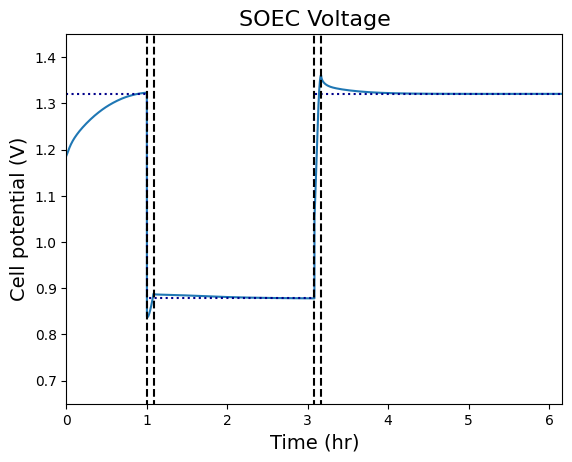

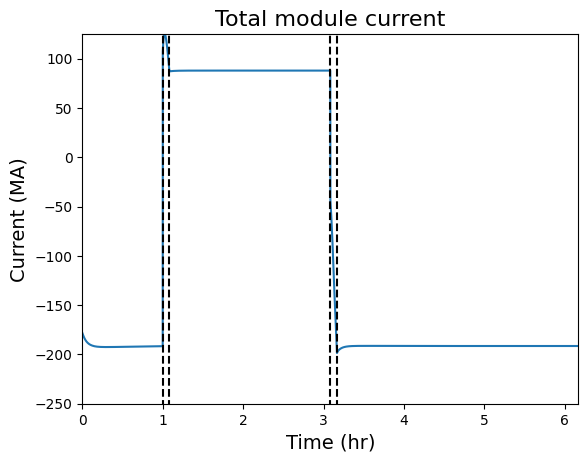

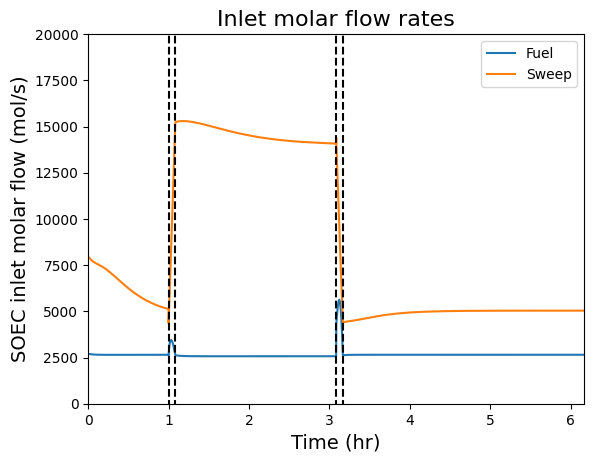

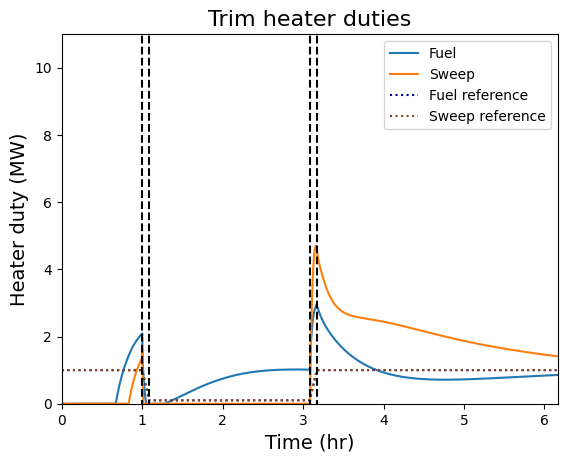

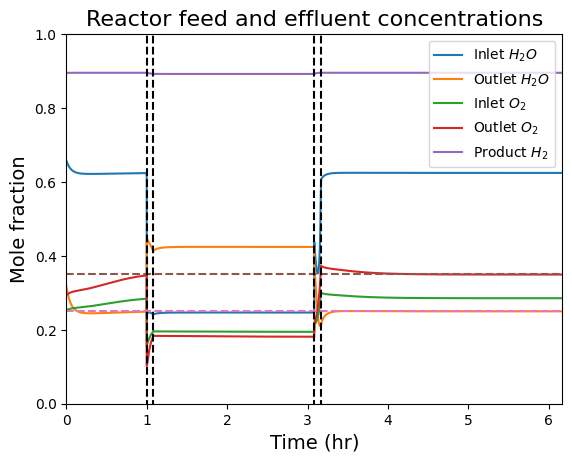

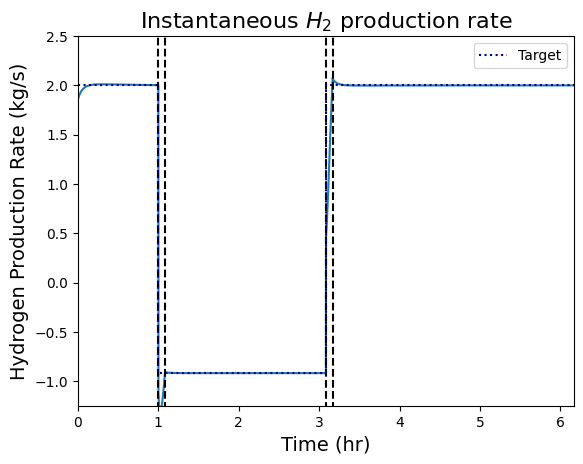

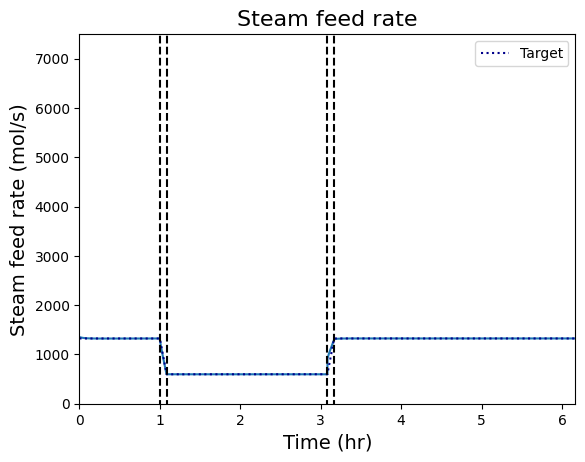

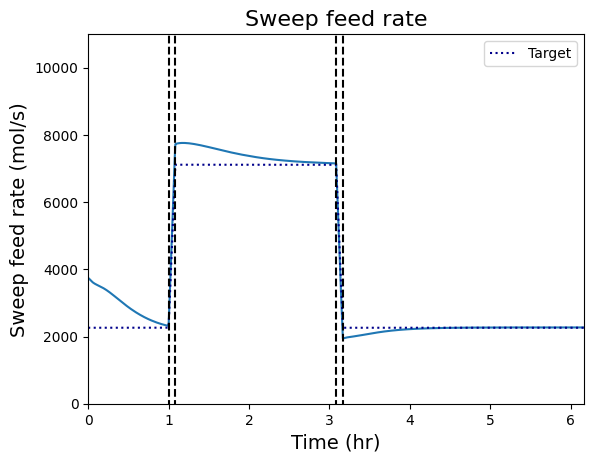

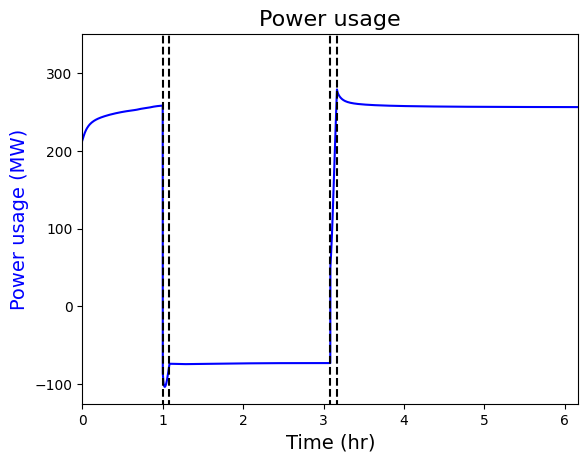

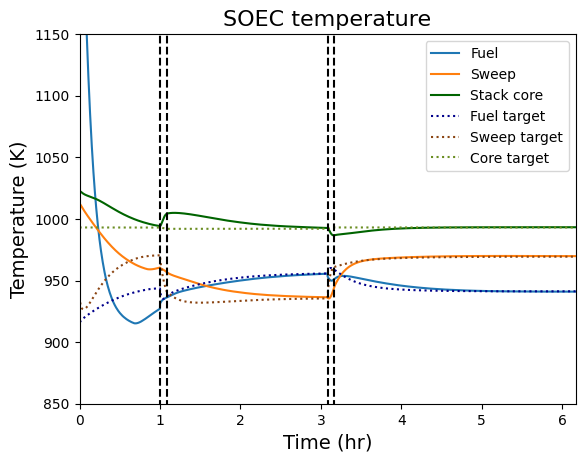

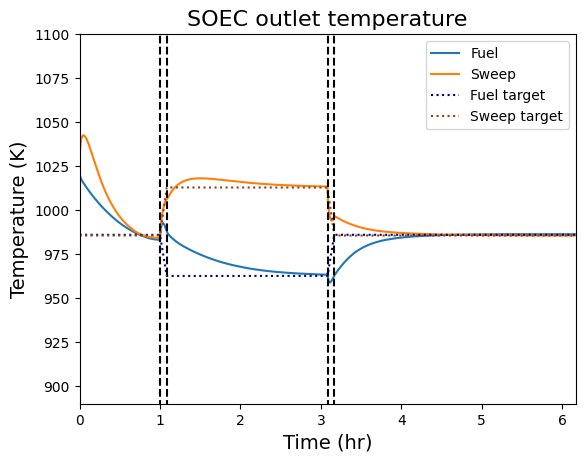

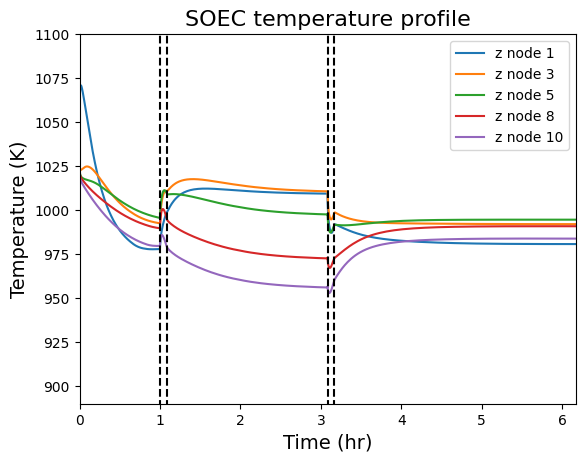

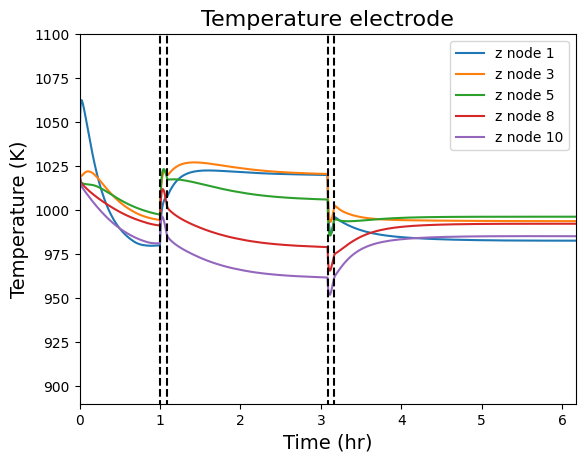

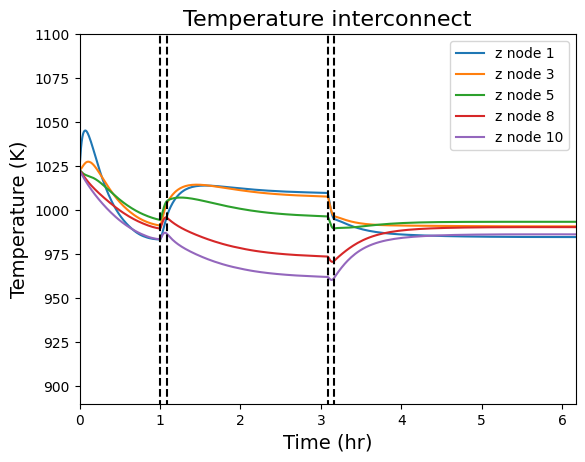

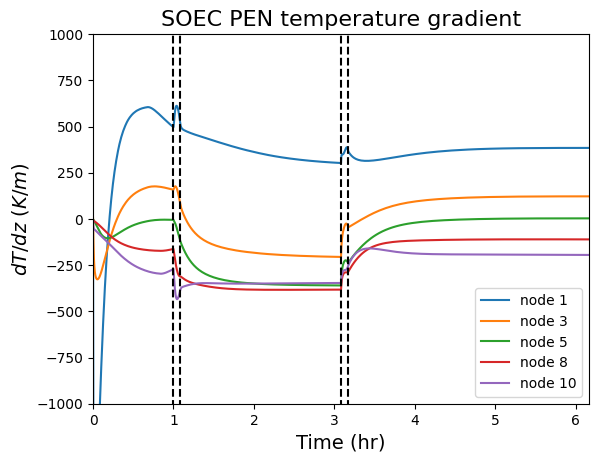

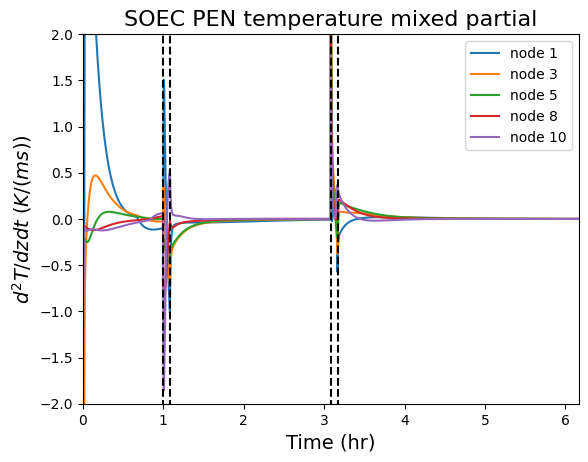

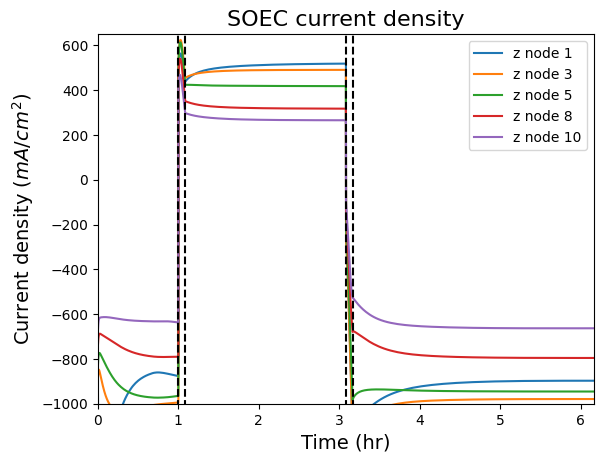

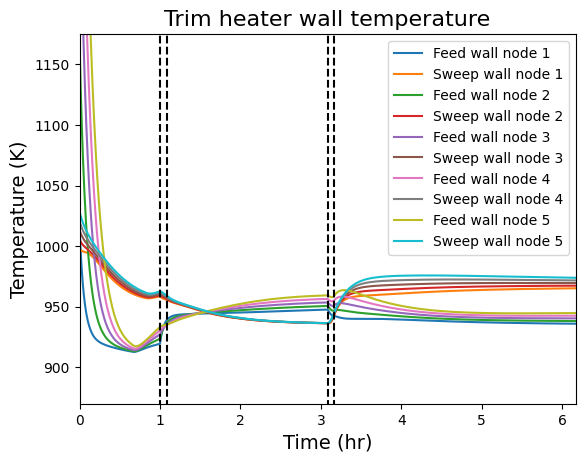

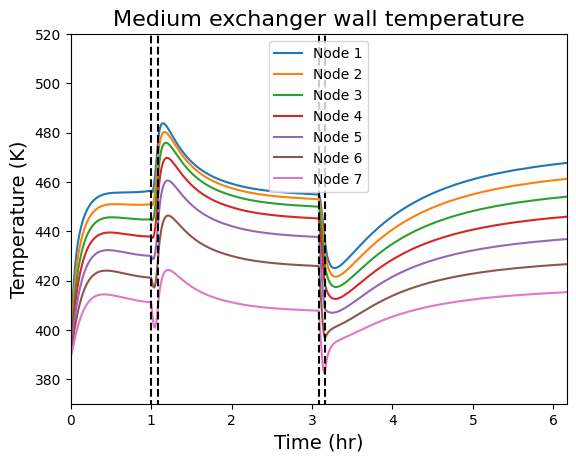

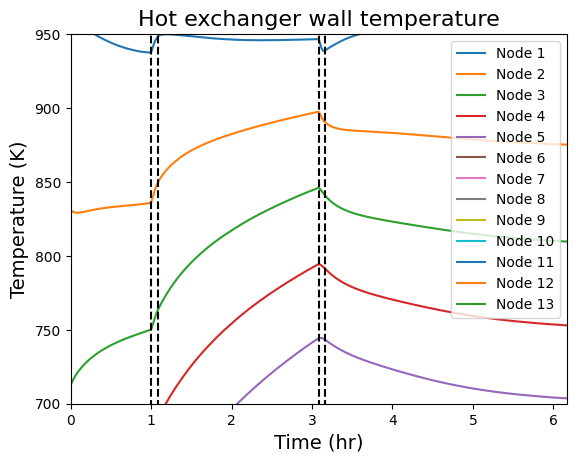

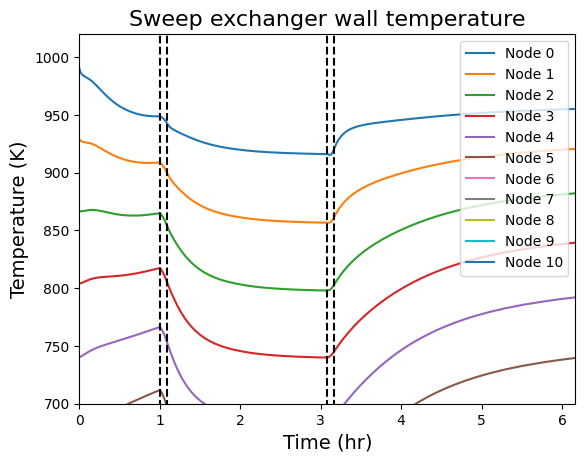

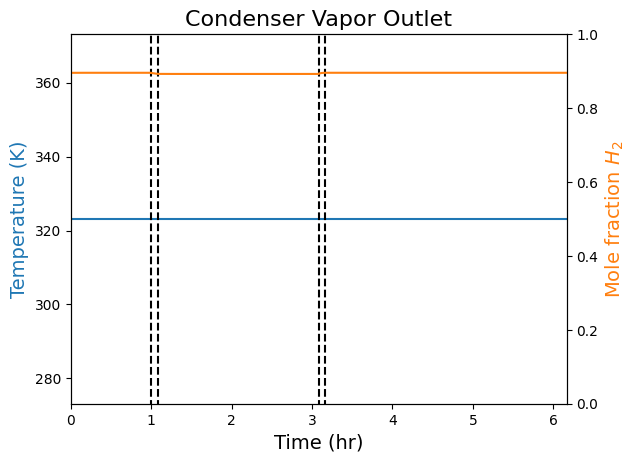

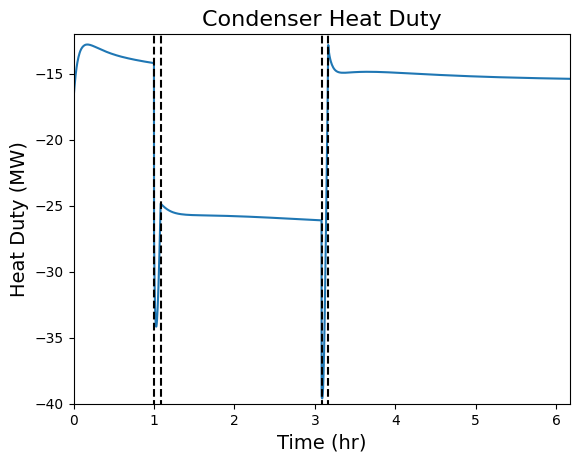

In [19]:
include_PI = True

for key, value in results_dict.items():
    # Turn n by 1 arrays in into vectors
    results_dict[key] = np.squeeze(value)

demarcate_ramps = lambda ax: _demarcate_ramps(ax, results_dict)

time = results_dict["time"] / 60 ** 2

ax_fontsize = 14
title_fontsize = 16
iz_plot = [1, 3, 5, 8, 10]

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, results_dict["potential"])
if include_PI:
    ax.plot(
        time,
        results_dict["voltage_controller_mv_ref"],
        color="darkblue",
        linestyle="dotted",
    )
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0.65, 1.45))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Cell potential (V)", fontsize=ax_fontsize)
ax.set_title("SOEC Voltage", fontsize=title_fontsize)

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, results_dict["current"]*1e-6)
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((-250, 125))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Current (MA)", fontsize=ax_fontsize)
ax.set_title("Total module current", fontsize=title_fontsize)

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, results_dict["soec_fuel_inlet_flow"], label="Fuel")
ax.plot(time, results_dict["soec_oxygen_inlet_flow"], label="Sweep")
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0, 20000))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("SOEC inlet molar flow (mol/s)", fontsize=ax_fontsize)
ax.set_title("Inlet molar flow rates", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, 1e-6 * results_dict["fuel_heater_duty"], label="Fuel", color="tab:blue")
ax.plot(time, 1e-6 * results_dict["sweep_heater_duty"], label="Sweep", color="tab:orange")
if include_PI:
    ax.plot(
        time,
        1e-6 * results_dict["feed_heater_inner_controller_mv_ref"],
        label="Fuel reference",
        color="darkblue",
        linestyle="dotted"
    )
    ax.plot(
        time,
        1e-6 * results_dict["sweep_heater_inner_controller_mv_ref"],
        label="Sweep reference",
        color="saddlebrown",
        linestyle="dotted"
    )
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0, 11))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Heater duty (MW)", fontsize=ax_fontsize)
ax.set_title("Trim heater duties", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, results_dict["fuel_inlet_H2O"], label="Inlet $H_2O$")
ax.plot(time, results_dict["fuel_outlet_H2O"], label="Outlet $H_2O$")
ax.plot(time, results_dict["sweep_inlet_O2"], label="Inlet $O_2$")
ax.plot(time, results_dict["sweep_outlet_O2"], label="Outlet $O_2$")
ax.plot(time, results_dict["product_mole_frac_H2"], label="Product $H_2$")
ax.plot(time, 0.35 * np.ones(time.shape), '--')
ax.plot(time, 0.25 * np.ones(time.shape), '--')
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0, 1))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Mole fraction", fontsize=ax_fontsize)
ax.set_title("Reactor feed and effluent concentrations", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, results_dict["H2_production"])
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((-1.25, 2.5))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Hydrogen Production Rate (kg/s)", fontsize=ax_fontsize)
ax.set_title("Instantaneous $H_2$ production rate", fontsize=title_fontsize)

if include_PI:
    ax.plot(
        time,
        results_dict["h2_production_rate_controller_setpoint"],
        label="Target",
        color="darkblue",
        linestyle="dotted"
    )
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, results_dict["steam_feed_rate"])
if include_PI:
    ax.plot(time,
            results_dict["h2_production_rate_controller_mv_ref"],
            label="Target",
            color="darkblue",
            linestyle="dotted"
    )
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0, 7500))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Steam feed rate (mol/s)", fontsize=ax_fontsize)
ax.set_title("Steam feed rate", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, results_dict["sweep_feed_rate"])
if include_PI:
    ax.plot(time,
            results_dict["sweep_blower_controller_mv_ref"],
            label="Target",
            color="darkblue",
            linestyle="dotted"
    )
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0, 11000))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Sweep feed rate (mol/s)", fontsize=ax_fontsize)
ax.set_title("Sweep feed rate", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, 1e-6 * results_dict["total_electric_power"], 'b', label="Total power")
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((-125, 350))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Power usage (MW)", color="blue", fontsize=ax_fontsize)
ax.set_title("Power usage", fontsize=title_fontsize)

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, results_dict["fuel_inlet_temperature"], label="Fuel", color="tab:blue")
ax.plot(time, results_dict["sweep_inlet_temperature"], label="Sweep", color="tab:orange")
ax.plot(time, results_dict["stack_core_temperature"], label="Stack core", color="darkgreen")

if include_PI:
    ax.plot(
        time,
        results_dict["feed_heater_inner_controller_setpoint"],
        label="Fuel target",
        color="darkblue",
        linestyle="dotted"
    )
    ax.plot(
        time,
        results_dict["sweep_heater_inner_controller_setpoint"],
        label="Sweep target",
        color="saddlebrown",
        linestyle="dotted"
    )
    ax.plot(
        time,
        results_dict["sweep_blower_controller_setpoint"],
        label="Core target",
        color="olivedrab",
        linestyle="dotted"
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((850, 1150))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
demarcate_ramps(ax)
ax.set_title("SOEC temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, results_dict["fuel_outlet_temperature"], label="Fuel", color="tab:blue")
ax.plot(time, results_dict["sweep_outlet_temperature"], label="Sweep", color="tab:orange")
if include_PI:
    ax.plot(
        time,
        results_dict["feed_heater_outer_controller_setpoint"],
        label="Fuel target",
        color="darkblue",
        linestyle="dotted"
    )
    ax.plot(
        time,
        results_dict["sweep_heater_outer_controller_setpoint"],
        label="Sweep target",
        color="saddlebrown",
        linestyle="dotted"
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((890, 1100))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
demarcate_ramps(ax)
ax.set_title("SOEC outlet temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(time, results_dict["temperature_z"][iz-1, :], label=f"z node {iz}")

ax.set_xlim(time[0], time[-1])
ax.set_ylim((890, 1100))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
demarcate_ramps(ax)
ax.set_title("SOEC temperature profile", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(
        time,
        results_dict["temperature_z"][iz-1, :] + results_dict["fuel_electrode_temperature_deviation_x"][iz-1, :],
        label=f"z node {iz}"
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((890, 1100))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
demarcate_ramps(ax)
ax.set_title("Temperature electrode", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(
        time,
        results_dict["temperature_z"][iz-1, :] + results_dict["interconnect_temperature_deviation_x"][iz-1, :],
        label=f"z node {iz}"
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((890, 1100))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
demarcate_ramps(ax)
ax.set_title("Temperature interconnect", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(
        time,
        results_dict["fuel_electrode_gradient"][iz-1, :],
        label=f"node {iz}"
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((-1000, 1000))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("$dT/dz$ ($K/m$)", fontsize=ax_fontsize)
ax.set_title("SOEC PEN temperature gradient", fontsize=title_fontsize)
demarcate_ramps(ax)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(
        time,
        results_dict["fuel_electrode_mixed_partial"][iz-1, :],
        label=f"node {iz}"
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((-2, 2))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("$d^2T/dzdt$ ($K/(m s)$)", fontsize=ax_fontsize)
ax.set_title("SOEC PEN temperature mixed partial", fontsize=title_fontsize)
demarcate_ramps(ax)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(time, results_dict["current_density"][iz-1, :] / 10, label=f"z node {iz}")

ax.set_xlim(time[0], time[-1])
# ax.set_ylim((575,875))
ax.set_ylim((-1000, 650))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Current density ($mA/cm^2$)", fontsize=ax_fontsize)
ax.set_title("SOEC current density", fontsize=title_fontsize)
demarcate_ramps(ax)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
for z in range(results_dict["feed_heater_temperature"].shape[0]):
    ax.plot(time, results_dict["feed_heater_temperature"][z, :], label=f"Feed wall node {z+1}")
    ax.plot(time, results_dict["sweep_heater_temperature"][z, :], label=f"Sweep wall node {z+1}")
ax.set_xlim(time[0], time[-1])
ax.set_ylim((870, 1175))
demarcate_ramps(ax)
ax.set_title("Trim heater wall temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
for z in range(results_dict["feed_medium_exchanger_temperature"].shape[0]):
    ax.plot(time,
            results_dict["feed_medium_exchanger_temperature"][z, :],
            label=f"Node {z + 1}")
ax.set_xlim(time[0], time[-1])
ax.set_ylim((370, 520))
demarcate_ramps(ax)
ax.set_title("Medium exchanger wall temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)

for z in range(results_dict["feed_hot_exchanger_temperature"].shape[0]):
    ax.plot(time,
            results_dict["feed_hot_exchanger_temperature"][z, :],
            label=f"Node {z + 1}")
ax.set_xlim(time[0], time[-1])
ax.set_ylim((700, 950))
demarcate_ramps(ax)
ax.set_title("Hot exchanger wall temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
for z in range(results_dict["sweep_exchanger_temperature"].shape[0]):
    ax.plot(time,
            results_dict["sweep_exchanger_temperature"][z, :],
            label=f"Node {z}")
ax.set_xlim(time[0], time[-1])
ax.set_ylim((700, 1020))
demarcate_ramps(ax)
ax.set_title("Sweep exchanger wall temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax2 = ax.twinx()

ax.plot(time, results_dict["condenser_outlet_temperature"], label="Temperature", color="tab:blue")
ax2.plot(time, results_dict["product_mole_frac_H2"], label="H2 mole fraction", color="tab:orange")

ax.set_xlim(time[0], time[-1])
ax.set_ylim((273.15, 373.15))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize, color="tab:blue")
ax2.set_ylim((0,1))
ax2.set_ylabel("Mole fraction $H_2$", fontsize=ax_fontsize,  color="tab:orange")

demarcate_ramps(ax)
ax.set_title("Condenser Vapor Outlet", fontsize=title_fontsize)

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, 1e-6*results_dict["condenser_heat_duty"])

ax.set_xlim(time[0], time[-1])
ax.set_ylim((-40, -12))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Heat Duty (MW)", fontsize=ax_fontsize)

demarcate_ramps(ax)
ax.set_title("Condenser Heat Duty", fontsize=title_fontsize)

plt.show()